In [1]:
###### import packages for analysis
import scanpy as sc
import pandas as pd
import numpy as np
import os
from matplotlib import rcParams
import seaborn as sb
import matplotlib.pyplot as plt
import anndata as ad
from scipy import sparse
from anndata import AnnData
import time
import MACA as maca
import seaborn as sns
from scipy import stats
from scipy.stats import ranksums
import bbknn as bbknn
import scipy.sparse as sp

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.3 scipy==1.10.0 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 louvain==0.8.0 pynndescent==0.5.6


In [74]:
# the file that will store the analysis results
#results_file = '/home/mmokhtari/INF_analysis/INF_analysis.h5ad' 

In [75]:
#reading the raw_feature_bc_matrix
adata = sc.read_10x_h5('/home/mmokhtari/INF_analysis/raw_feature_bc_matrix.h5')

reading /home/mmokhtari/INF_analysis/raw_feature_bc_matrix.h5
 (0:00:02)


In [76]:
adata_DONE_WITH_pDCs = sc.read_h5ad('/home/mmokhtari/INF_analysis/INF_analysis_with_pDC.h5ad')

In [77]:
adata_DONE_WITH_pDCs.obs

donor  n_genes_by_counts  total_counts leiden  \
AAACCCAAGACTGGGT-1  donor1               1051        3960.0     10   
AAACCCAAGGATATGT-1  donor1               2930        7565.0      0   
AAACCCAAGGGATCGT-1  donor0                887        1383.0     13   
AAACCCACAATGTCAC-1  donor0               1512        3370.0      3   
AAACCCACAGATCCAT-1  donor0               1974        4135.0      3   
...                    ...                ...           ...    ...   
ACTGTCCAGTGGAATT-1  donor1               2230        4979.0     16   
ATGGGAGTCTCAACGA-1  donor1               2328        6750.0     16   
GTCCTCAGTATCCCAA-1  donor1               2736        9355.0     16   
TAGAGTCCACTGATTG-1  donor1               3075       15090.0     16   
TGCTTCGGTCGGTGAA-1  donor1               2783       15077.0     16   

                                 Ann_az_default                annotation_AZ  \
AAACCCAAGACTGGGT-1                            B                Memory B cell   
AAACCCAAGGATATGT-1                           NK   CD56-bright Natural Killer   
AAACCCAAGGGATCGT-1                       CD8+_T        CD8+ Central Memory T   
AAACCCACAATGTCAC-1                           NK      CD56-dim Natural Killer   
AAACCCACAGATCCAT-1                           NK      CD56-dim Natural Killer   
...                                         ...                          ...   
ACTGTCCAGTGGAATT-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
ATGGGAGTCTCAACGA-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
GTCCTCAGTATCCCAA-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
TAGAGTCCACTGATTG-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
TGCTTCGGTCGGTGAA-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   

                                 annotation_MACA Final_Annotation  \
AAACCCAAGACTGGGT-1                       B cells                B   
AAACCCAAGGATATGT-1                      NK cells               NK   
AAACCCAAGGGATCGT-1                       T cells           CD8+_T   
AAACCCACAATGTCAC-1                      NK cells               NK   
AAACCCACAGATCCAT-1                      NK cells               NK   
...                                          ...              ...   
ACTGTCCAGTGGAATT-1                    unassigned              pDC   
ATGGGAGTCTCAACGA-1                    unassigned              pDC   
GTCCTCAGTATCCCAA-1  Plasmacytoid dendritic cells              pDC   
TAGAGTCCACTGATTG-1               Dendritic cells              pDC   
TGCTTCGGTCGGTGAA-1               Dendritic cells              pDC   

                   cell_type_donor  
AAACCCAAGACTGGGT-1        B-donor1  
AAACCCAAGGATATGT-1       NK-donor1  
AAACCCAAGGGATCGT-1   CD8+_T-donor0  
AAACCCACAATGTCAC-1       NK-donor0  
AAACCCACAGATCCAT-1       NK-donor0  
...                            ...  
ACTGTCCAGTGGAATT-1      pDC-donor1  
ATGGGAGTCTCAACGA-1      pDC-donor1  
GTCCTCAGTATCCCAA-1      pDC-donor1  
TAGAGTCCACTGATTG-1      pDC-donor1  
TGCTTCGGTCGGTGAA-1      pDC-donor1  

[9281 rows x 9 columns]

In [78]:
adata_DONE_WITH_pDCs[adata_DONE_WITH_pDCs.obs.Final_Annotation=="pDC"]

View of AnnData object with n_obs × n_vars = 21 × 1016
    obs: 'donor', 'n_genes_by_counts', 'total_counts', 'leiden', 'Ann_az_default', 'annotation_AZ', 'annotation_MACA', 'Final_Annotation', 'cell_type_donor'
    uns: 'Final_Annotation_colors', 'cell_type_donor_colors', 'dendrogram_Final_Annotation', 'donor_colors'
    obsm: 'X_pca', 'X_umap'

In [79]:
dup=adata_DONE_WITH_pDCs[adata_DONE_WITH_pDCs.obs.index.duplicated()].obs.index.tolist()

In [80]:
adata_DONE_WITH_pDCs_dups = adata_DONE_WITH_pDCs[adata_DONE_WITH_pDCs.obs.index.isin(dup)]
adata_DONE_WITH_pDCs_dups = adata_DONE_WITH_pDCs_dups[adata_DONE_WITH_pDCs_dups.obs.Final_Annotation=="pDC"]
adata_DONE_WITH_pDCs_dups.obs

donor  n_genes_by_counts  total_counts leiden  \
CAACAACAGGAGTACC-1  donor1               2614       10155.0     16   
CACCGTTAGCTTTGTG-1  donor1               1370        4719.0     16   
CATCCGTCATCGCTAA-1  donor1               1554        4536.0     16   
CCCTAACTCACCATGA-1  donor1               2387        7175.0     16   
CCTCAGTCACCCTAGG-1  donor0               2922       13514.0     16   
CGGACACCAAGCCATT-1  donor1               2763       13594.0     16   
CGTGAATTCATTATCC-1  donor1               2659       12424.0     16   
CTGCCTAAGTTGCCTA-1  donor1               3008        9721.0     16   
CTTGAGAGTCTAGGCC-1  donor1               1773        5567.0     16   
GACGTTAGTCGGTGTC-1  donor1               1911        7587.0     16   
GCAGTTAGTTCCCACT-1  donor1               2867       12705.0     16   
GTAAGTCGTAGGCAAC-1  donor1               2494        8314.0     16   
GTCACGGCAATAACGA-1  donor1               2426        7366.0     16   
TCACATTAGAGTGTTA-1  donor1               2429        9860.0     16   
TGTCAGACAACACGTT-1  donor1               2860        9857.0     16   
TTTACGTGTGAGTAGC-1  donor1               2445        8387.0     16   

                                 Ann_az_default                annotation_AZ  \
CAACAACAGGAGTACC-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CACCGTTAGCTTTGTG-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CATCCGTCATCGCTAA-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CCCTAACTCACCATGA-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CCTCAGTCACCCTAGG-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CGGACACCAAGCCATT-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CGTGAATTCATTATCC-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CTGCCTAAGTTGCCTA-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CTTGAGAGTCTAGGCC-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
GACGTTAGTCGGTGTC-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
GCAGTTAGTTCCCACT-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
GTAAGTCGTAGGCAAC-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
GTCACGGCAATAACGA-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
TCACATTAGAGTGTTA-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
TGTCAGACAACACGTT-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
TTTACGTGTGAGTAGC-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   

                    annotation_MACA Final_Annotation cell_type_donor  
CAACAACAGGAGTACC-1       unassigned              pDC      pDC-donor1  
CACCGTTAGCTTTGTG-1  Dendritic cells              pDC      pDC-donor1  
CATCCGTCATCGCTAA-1       unassigned              pDC      pDC-donor1  
CCCTAACTCACCATGA-1       unassigned              pDC      pDC-donor1  
CCTCAGTCACCCTAGG-1  Dendritic cells              pDC      pDC-donor0  
CGGACACCAAGCCATT-1  Dendritic cells              pDC      pDC-donor1  
CGTGAATTCATTATCC-1  Dendritic cells              pDC      pDC-donor1  
CTGCCTAAGTTGCCTA-1       unassigned              pDC      pDC-donor1  
CTTGAGAGTCTAGGCC-1       unassigned              pDC      pDC-donor1  
GACGTTAGTCGGTGTC-1       unassigned              pDC      pDC-donor1  
GCAGTTAGTTCCCACT-1  Dendritic cells              pDC      pDC-donor1  
GTAAGTCGTAGGCAAC-1       unassigned              pDC      pDC-donor1  
GTCACGGCAATAACGA-1       unassigned              pDC      pDC-donor1  
TCACATTAGAGTGTTA-1  Dendritic cells              pDC      pDC-donor1  
TGTCAGACAACACGTT-1       unassigned              pDC      pDC-donor1  
TTTACGTGTGAGTAGC-1       unassigned              pDC      pDC-donor1

In [81]:
adata_DONE_WITH_pDCs

AnnData object with n_obs × n_vars = 9281 × 1016
    obs: 'donor', 'n_genes_by_counts', 'total_counts', 'leiden', 'Ann_az_default', 'annotation_AZ', 'annotation_MACA', 'Final_Annotation', 'cell_type_donor'
    uns: 'Final_Annotation_colors', 'cell_type_donor_colors', 'dendrogram_Final_Annotation', 'donor_colors'
    obsm: 'X_pca', 'X_umap'

In [82]:
adata_DONE_WITH_pDCs = adata_DONE_WITH_pDCs[~adata_DONE_WITH_pDCs.obs.index.isin(dup)]


In [83]:
adata_DONE_WITH_pDCs

View of AnnData object with n_obs × n_vars = 9249 × 1016
    obs: 'donor', 'n_genes_by_counts', 'total_counts', 'leiden', 'Ann_az_default', 'annotation_AZ', 'annotation_MACA', 'Final_Annotation', 'cell_type_donor'
    uns: 'Final_Annotation_colors', 'cell_type_donor_colors', 'dendrogram_Final_Annotation', 'donor_colors'
    obsm: 'X_pca', 'X_umap'

In [84]:
new_list=[adata_DONE_WITH_pDCs_dups,adata_DONE_WITH_pDCs]
adata_DONE_WITH_pDCs = ad.concat(new_list)

In [85]:
adata_DONE_WITH_pDCs[adata_DONE_WITH_pDCs.obs.index.duplicated()].obs

Empty DataFrameView
Columns: [donor, n_genes_by_counts, total_counts, leiden, Ann_az_default, annotation_AZ, annotation_MACA, Final_Annotation, cell_type_donor]
Index: []

In [86]:
adata_DONE_WITH_pDCs[adata_DONE_WITH_pDCs.obs.Final_Annotation=="pDC"]

View of AnnData object with n_obs × n_vars = 21 × 1016
    obs: 'donor', 'n_genes_by_counts', 'total_counts', 'leiden', 'Ann_az_default', 'annotation_AZ', 'annotation_MACA', 'Final_Annotation', 'cell_type_donor'
    obsm: 'X_pca', 'X_umap'

In [87]:
list_CELLS_TO_KEEP=adata_DONE_WITH_pDCs.obs.index.tolist()

In [88]:
adata[:, adata.var.index == "TLR9"].var

gene_ids    feature_types  genome
TLR9  ENSG00000239732  Gene Expression  GRCh38

In [89]:
adata_final_filtered=adata[adata.obs.index.isin(list_CELLS_TO_KEEP)]

In [90]:
adata_final_filtered[:, adata_final_filtered.var.index == "TLR9"].var

gene_ids    feature_types  genome
TLR9  ENSG00000239732  Gene Expression  GRCh38

In [91]:
adata_DONE_WITH_pDCs.obs.head(10)

donor  n_genes_by_counts  total_counts leiden  \
CAACAACAGGAGTACC-1  donor1               2614       10155.0     16   
CACCGTTAGCTTTGTG-1  donor1               1370        4719.0     16   
CATCCGTCATCGCTAA-1  donor1               1554        4536.0     16   
CCCTAACTCACCATGA-1  donor1               2387        7175.0     16   
CCTCAGTCACCCTAGG-1  donor0               2922       13514.0     16   
CGGACACCAAGCCATT-1  donor1               2763       13594.0     16   
CGTGAATTCATTATCC-1  donor1               2659       12424.0     16   
CTGCCTAAGTTGCCTA-1  donor1               3008        9721.0     16   
CTTGAGAGTCTAGGCC-1  donor1               1773        5567.0     16   
GACGTTAGTCGGTGTC-1  donor1               1911        7587.0     16   

                                 Ann_az_default                annotation_AZ  \
CAACAACAGGAGTACC-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CACCGTTAGCTTTGTG-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CATCCGTCATCGCTAA-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CCCTAACTCACCATGA-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CCTCAGTCACCCTAGG-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CGGACACCAAGCCATT-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CGTGAATTCATTATCC-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CTGCCTAAGTTGCCTA-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
CTTGAGAGTCTAGGCC-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   
GACGTTAGTCGGTGTC-1  Plasmacytoid Dendritic Cell  Plasmacytoid Dendritic Cell   

                    annotation_MACA Final_Annotation cell_type_donor  
CAACAACAGGAGTACC-1       unassigned              pDC      pDC-donor1  
CACCGTTAGCTTTGTG-1  Dendritic cells              pDC      pDC-donor1  
CATCCGTCATCGCTAA-1       unassigned              pDC      pDC-donor1  
CCCTAACTCACCATGA-1       unassigned              pDC      pDC-donor1  
CCTCAGTCACCCTAGG-1  Dendritic cells              pDC      pDC-donor0  
CGGACACCAAGCCATT-1  Dendritic cells              pDC      pDC-donor1  
CGTGAATTCATTATCC-1  Dendritic cells              pDC      pDC-donor1  
CTGCCTAAGTTGCCTA-1       unassigned              pDC      pDC-donor1  
CTTGAGAGTCTAGGCC-1       unassigned              pDC      pDC-donor1  
GACGTTAGTCGGTGTC-1       unassigned              pDC      pDC-donor1

In [92]:
#adata_final_filtered.obs["Final_Annotation"]=adata_DONE_WITH_pDCs.obs["Final_Annotation"]
#adata_final_filtered.obs["cell_type_donor"]==adata_DONE_WITH_pDCs.obs.cell_type_donor

In [93]:
keep_annot=dict(zip(adata_DONE_WITH_pDCs.obs.index.tolist(),adata_DONE_WITH_pDCs.obs.Final_Annotation.tolist()))
keep_donor=dict(zip(adata_DONE_WITH_pDCs.obs.index.tolist(),adata_DONE_WITH_pDCs.obs.donor.tolist()))
keep_cell_type_donor=dict(zip(adata_DONE_WITH_pDCs.obs.index.tolist(),adata_DONE_WITH_pDCs.obs.cell_type_donor.tolist()))

In [94]:
adata_final_filtered.obs["Final_Annotation"] = adata_final_filtered.obs.index.map(keep_annot).astype("category")
adata_final_filtered.obs["donor"] = adata_final_filtered.obs.index.map(keep_donor).astype("category")
adata_final_filtered.obs["cell_type_donor"] = adata_final_filtered.obs.index.map(keep_cell_type_donor).astype("category")

In [95]:
adata_final_filtered.obs.cell_type_donor=adata_final_filtered.obs.cell_type_donor.str.replace("-","_")

In [96]:
adata_DONE_WITH_pDCs

AnnData object with n_obs × n_vars = 9265 × 1016
    obs: 'donor', 'n_genes_by_counts', 'total_counts', 'leiden', 'Ann_az_default', 'annotation_AZ', 'annotation_MACA', 'Final_Annotation', 'cell_type_donor'
    obsm: 'X_pca', 'X_umap'

In [97]:
adata_final_filtered[:, adata_final_filtered.var.index == "TLR9"].var

gene_ids    feature_types  genome
TLR9  ENSG00000239732  Gene Expression  GRCh38

In [98]:
adata_final_filtered.obs.head(10)

Final_Annotation   donor        cell_type_donor
AAACCCAAGACTGGGT-1                B  donor1               B_donor1
AAACCCAAGGATATGT-1               NK  donor1              NK_donor1
AAACCCAAGGGATCGT-1           CD8+_T  donor0          CD8+_T_donor0
AAACCCACAATGTCAC-1               NK  donor0              NK_donor0
AAACCCACAGATCCAT-1               NK  donor0              NK_donor0
AAACCCAGTATGTCTG-1                B  donor0               B_donor0
AAACCCAGTGGCTGAA-1           CD8+_T  donor1          CD8+_T_donor1
AAACCCAGTTCTCTCG-1                B  donor0               B_donor0
AAACCCATCATGAAAG-1           CD8+_T  donor0          CD8+_T_donor0
AAACCCATCGAACCAT-1   CD14+_Monocyte  donor0  CD14+_Monocyte_donor0

In [99]:
adata_final_filtered[adata_final_filtered.obs.Final_Annotation=="pDC"]

View of AnnData object with n_obs × n_vars = 21 × 20639
    obs: 'Final_Annotation', 'donor', 'cell_type_donor'
    var: 'gene_ids', 'feature_types', 'genome'

In [100]:
adata_final_filtered = adata_final_filtered.copy()

In [101]:
adata_final_filtered.var_names_make_unique()

In [102]:
adata_final_filtered[:, adata_final_filtered.var.index == "TLR9"].var

gene_ids    feature_types  genome
TLR9  ENSG00000239732  Gene Expression  GRCh38

normalizing counts per cell
    finished (0:00:00)


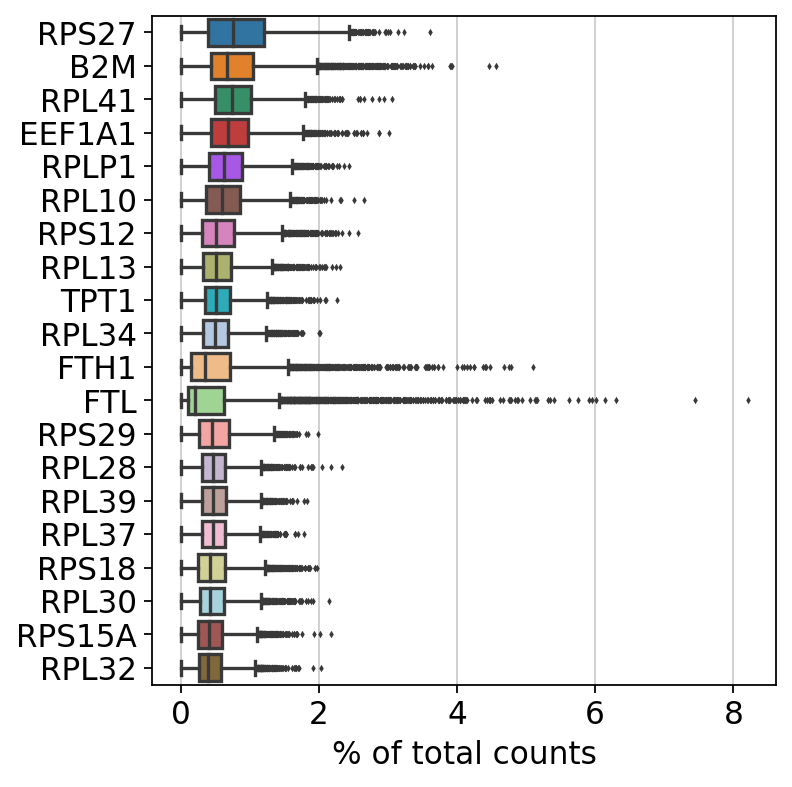

In [103]:
#genes with highest fraction of counts
sc.pl.highest_expr_genes(adata_final_filtered, n_top=20, )

In [104]:
adata_final_filtered[:, adata_final_filtered.var.index == "TLR9"].var

gene_ids    feature_types  genome
TLR9  ENSG00000239732  Gene Expression  GRCh38

In [105]:
#filtering the cells with low unique gene number and genes expressed in few cells
sc.pp.filter_cells(adata_final_filtered, min_genes=200)
sc.pp.filter_genes(adata_final_filtered, min_cells=2)

filtered out 3759 genes that are detected in less than 2 cells


In [106]:
adata_final_filtered[:, adata_final_filtered.var.index == "TLR9"].var

gene_ids    feature_types  genome  n_cells
TLR9  ENSG00000239732  Gene Expression  GRCh38        2

In [107]:
# annotate the group of mitochondrial genes as 'mt'
adata_final_filtered.var['mt'] = adata_final_filtered.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata_final_filtered, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

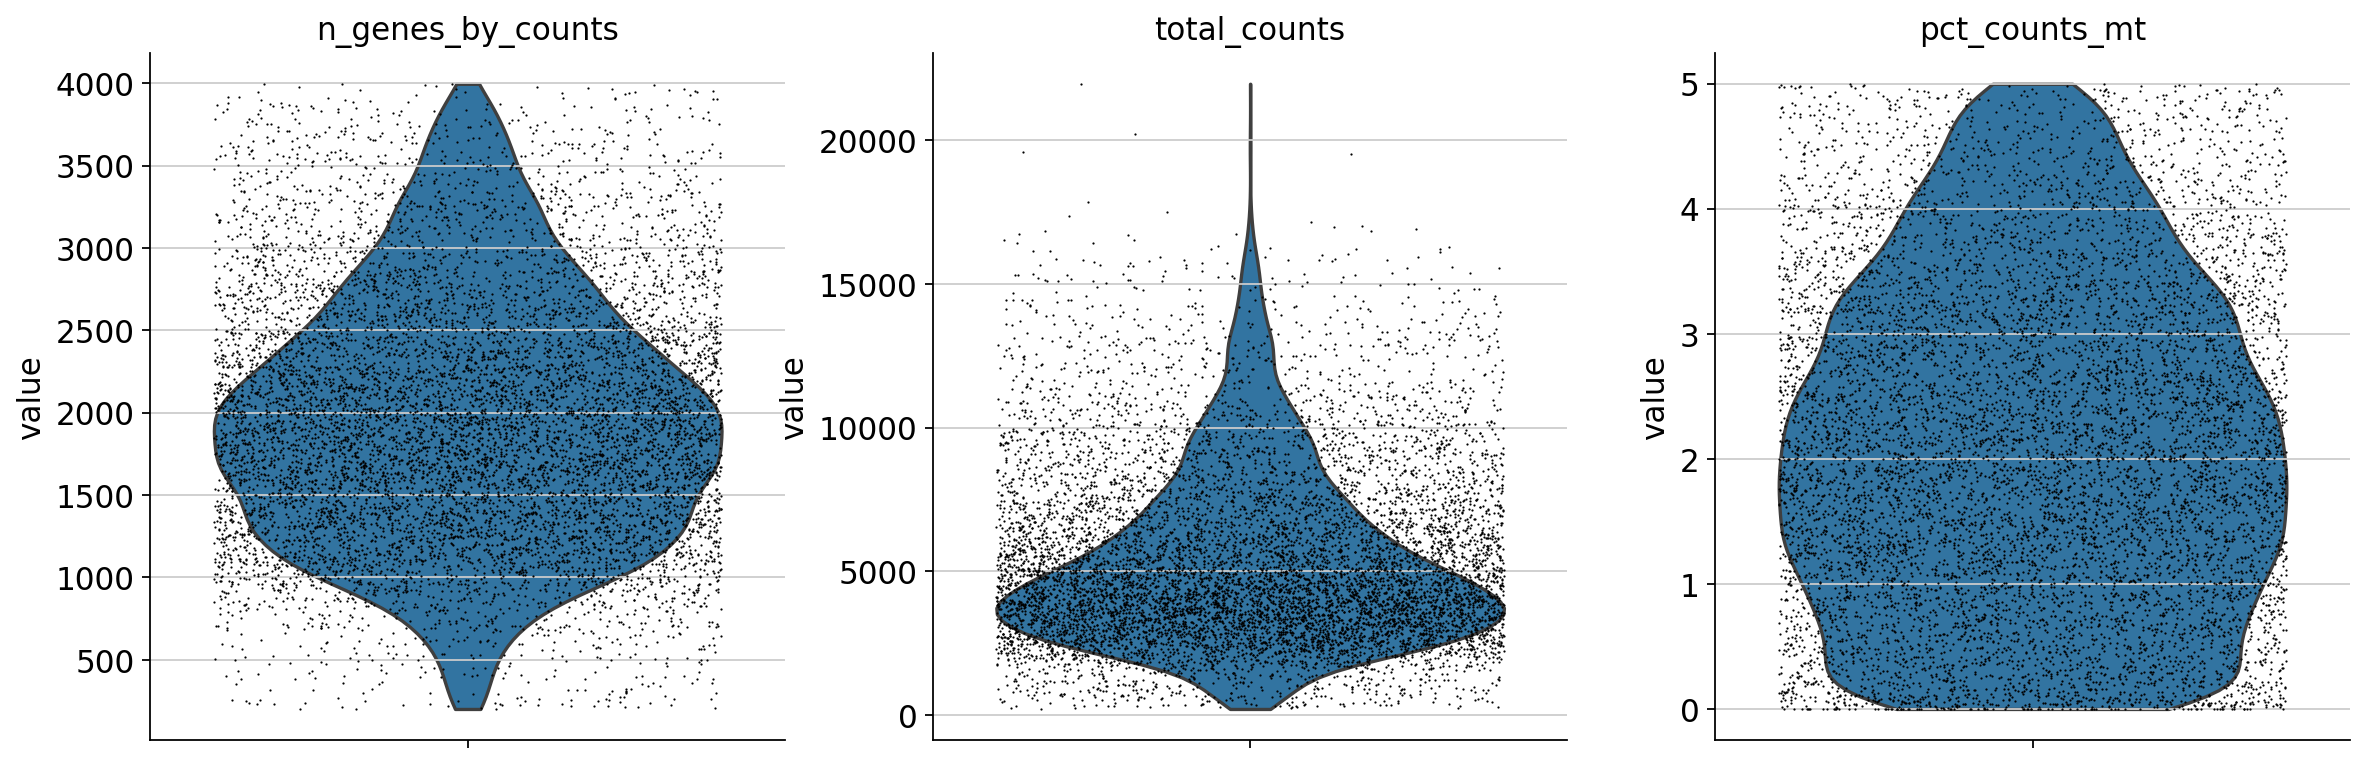

In [108]:
#A violin plot of some of the computed quality measures
adata_final_filtered.var_names_make_unique()
sc.pl.violin(adata_final_filtered, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

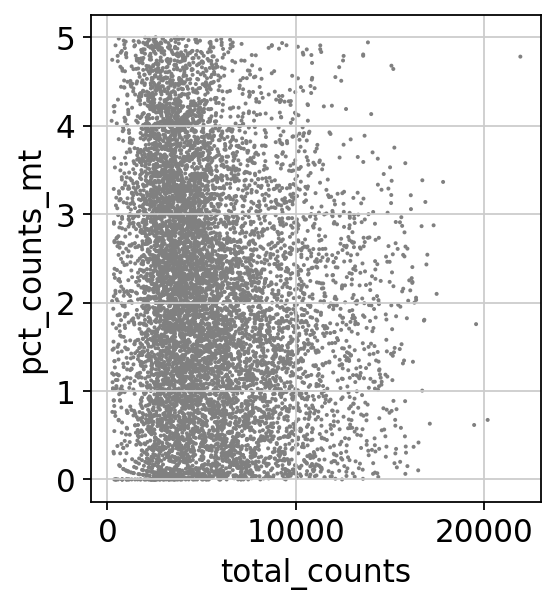

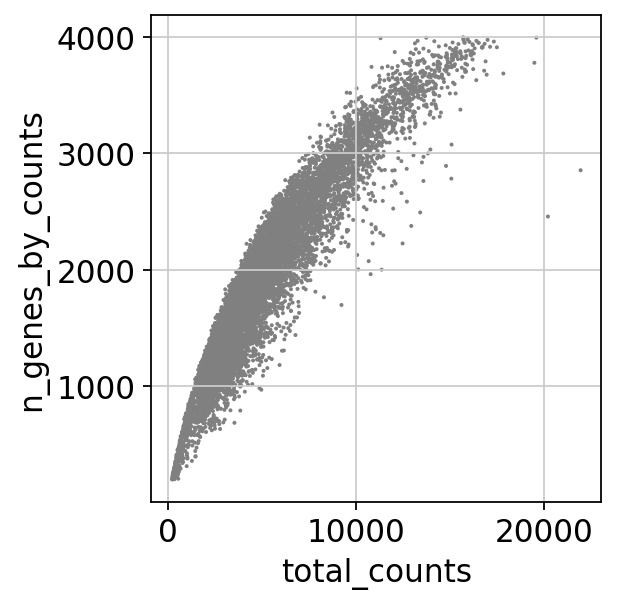

In [109]:
sc.pl.scatter(adata_final_filtered, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_final_filtered, x='total_counts', y='n_genes_by_counts')

In [110]:
#filtering for mts and n_genes_by_counts
adata_final_filtered = adata_final_filtered[adata_final_filtered.obs.n_genes_by_counts < 4000, :]
adata_final_filtered = adata_final_filtered[adata_final_filtered.obs.pct_counts_mt < 5, :]

In [111]:
adata_final_filtered = adata_final_filtered.copy()

In [112]:
adata_final_filtered

AnnData object with n_obs × n_vars = 9265 × 16880
    obs: 'Final_Annotation', 'donor', 'cell_type_donor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [113]:
adata_final_filtered[:, adata_final_filtered.var.index == "TLR9"].var

gene_ids    feature_types  genome  n_cells     mt  \
TLR9  ENSG00000239732  Gene Expression  GRCh38        2  False   

      n_cells_by_counts  mean_counts  pct_dropout_by_counts  total_counts  
TLR9                  2     0.000216              99.978413           2.0

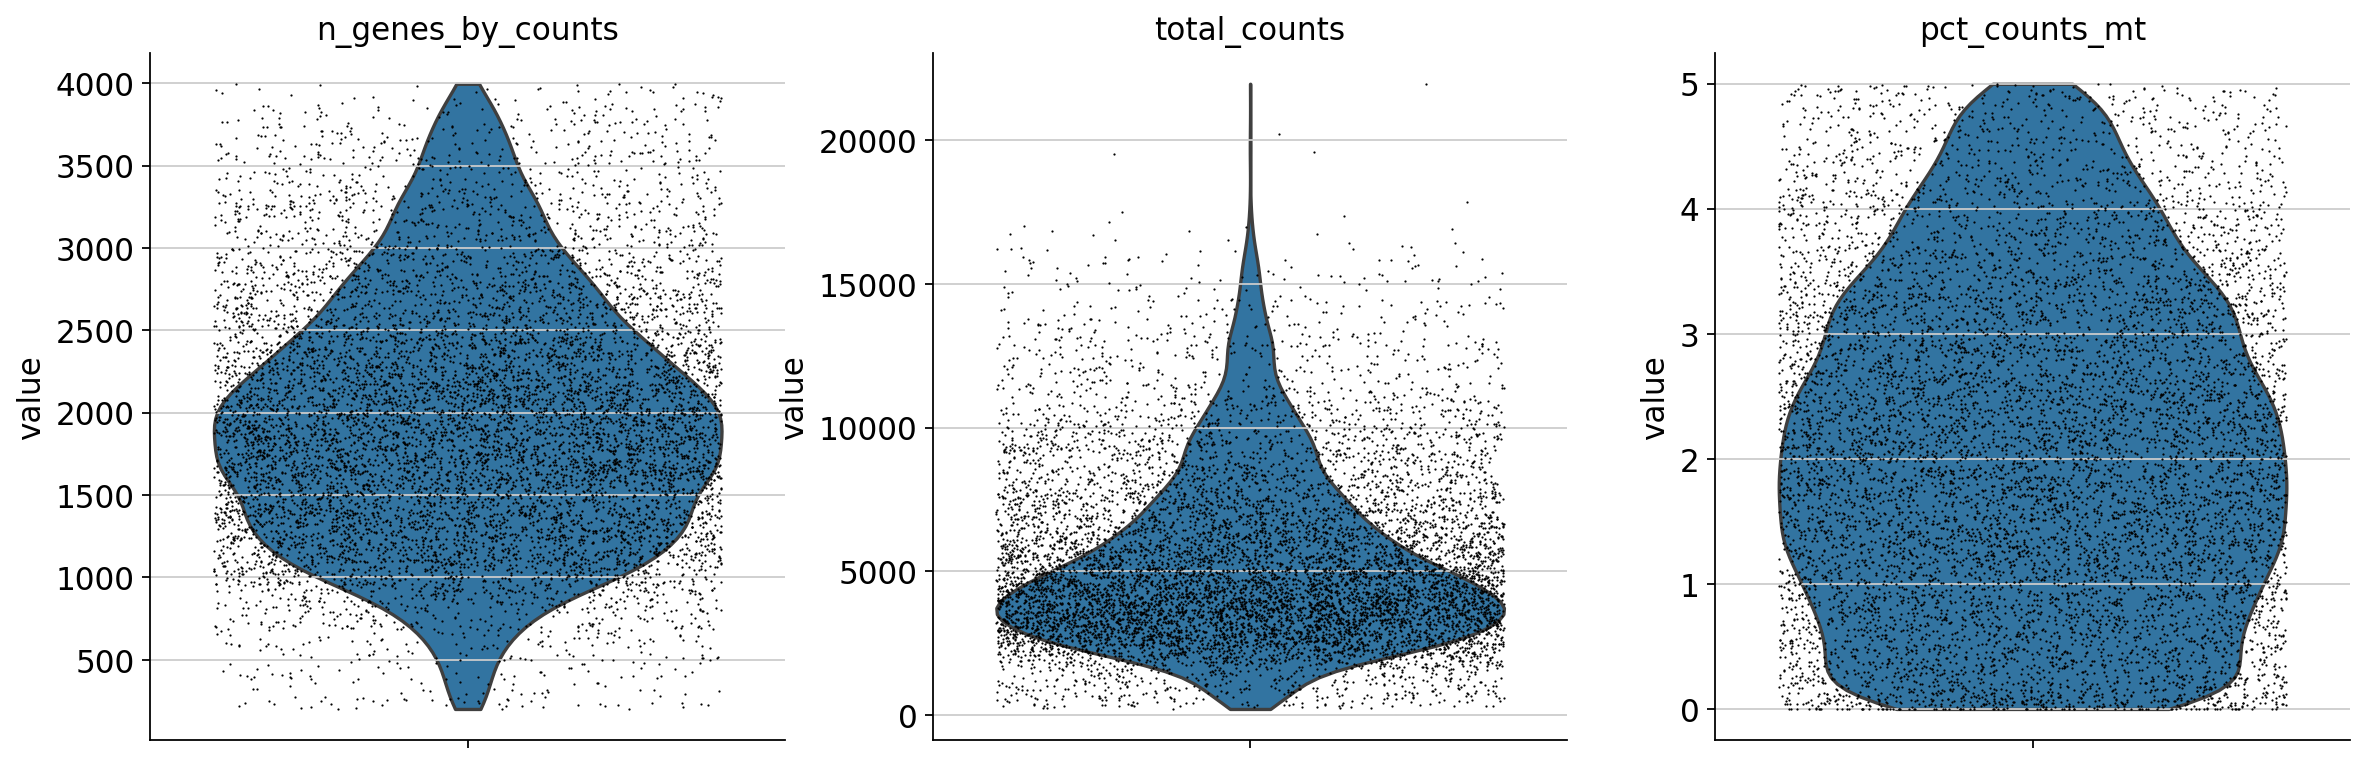

In [114]:
#A violin plot of some of the computed quality measures after filtering for mt and n_genes_by_ncounts
adata_final_filtered.var_names_make_unique()
sc.pl.violin(adata_final_filtered, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [44]:
#count normalizing the data
sc.pp.normalize_total(adata_final_filtered, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [45]:
#logaritmazing the data
sc.pp.log1p(adata_final_filtered)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


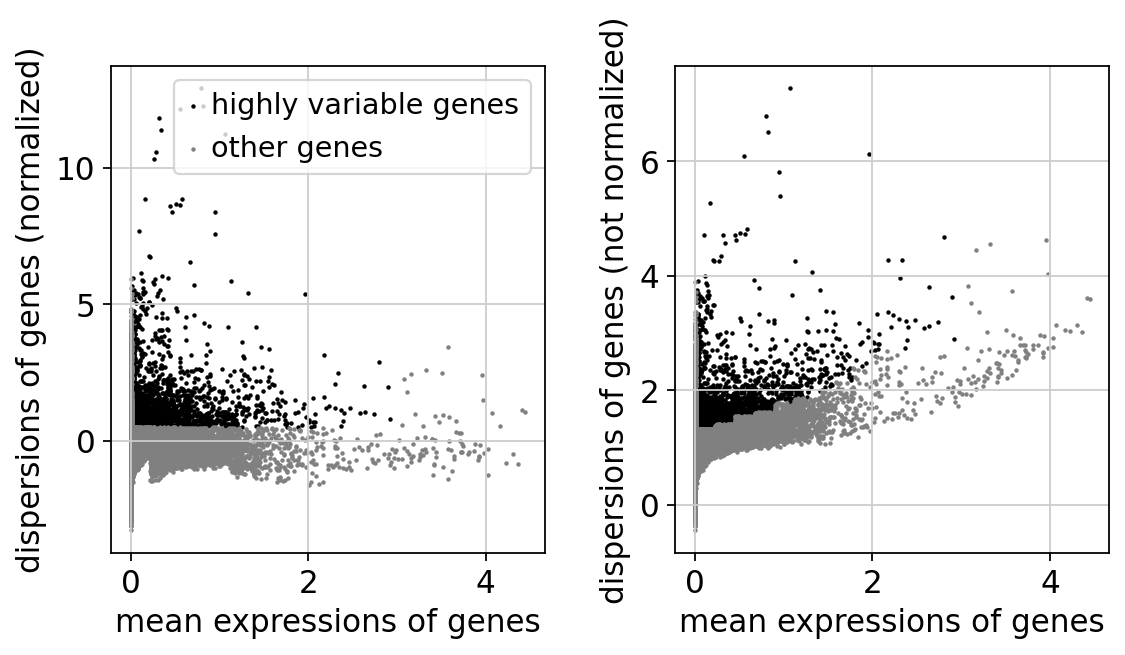

In [46]:
#Identify highly-variable genes
sc.pp.highly_variable_genes(adata_final_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_final_filtered)

normalizing counts per cell
    finished (0:00:00)


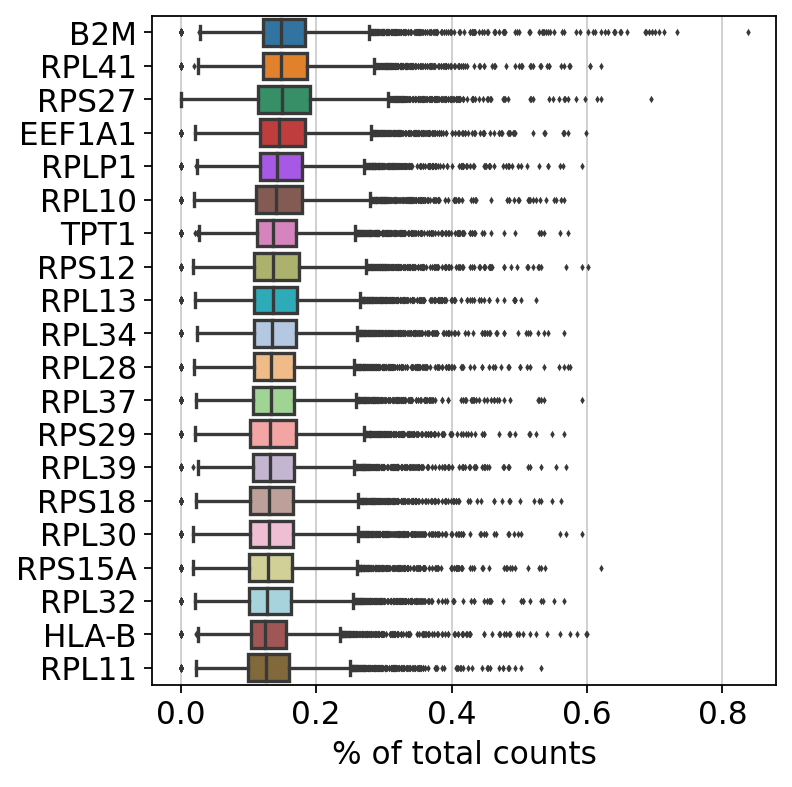

In [47]:
#highest expressed genes
sc.pl.highest_expr_genes(adata_final_filtered, n_top=20, )

In [ ]:
adata_final_filtered

In [49]:
adata_final_filtered.raw = adata_final_filtered


In [50]:
adata_final_filtered = adata_final_filtered[:, adata_final_filtered.var.highly_variable]


In [52]:
adata_final_filtered

AnnData object with n_obs × n_vars = 9265 × 2464
    obs: 'Final_Annotation', 'donor', 'cell_type_donor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [51]:
adata_final_filtered = adata_final_filtered.copy()

In [51]:
#Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
#sc.pp.regress_out(adata_final_filtered, ['total_counts', 'pct_counts_mt'])


In [52]:
#Scale each gene to unit variance
sc.pp.scale(adata_final_filtered, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [53]:
#running PCA
sc.tl.pca(adata_final_filtered, svd_solver='arpack')


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


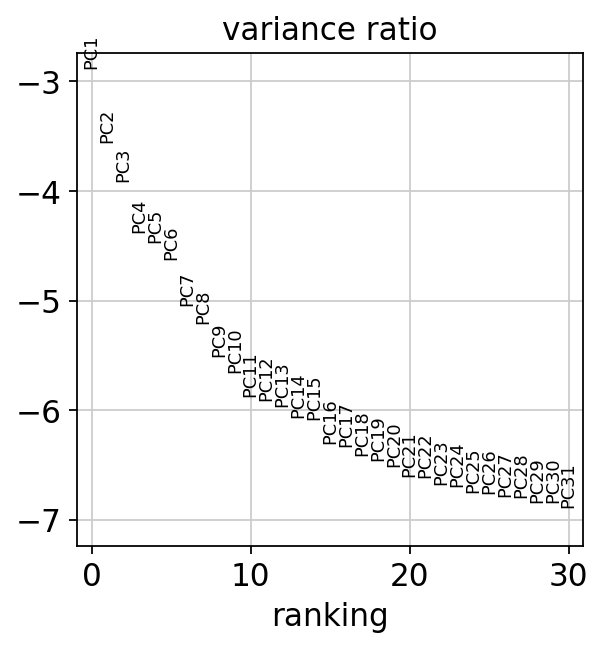

In [54]:
sc.pl.pca_variance_ratio(adata_final_filtered, log=True)


In [55]:
#adata_final_filtered.write(results_file)


In [56]:
#Computing the neighborhood graph
sc.pp.neighbors(adata_final_filtered, n_neighbors=10, n_pcs=40)


computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:06:14)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


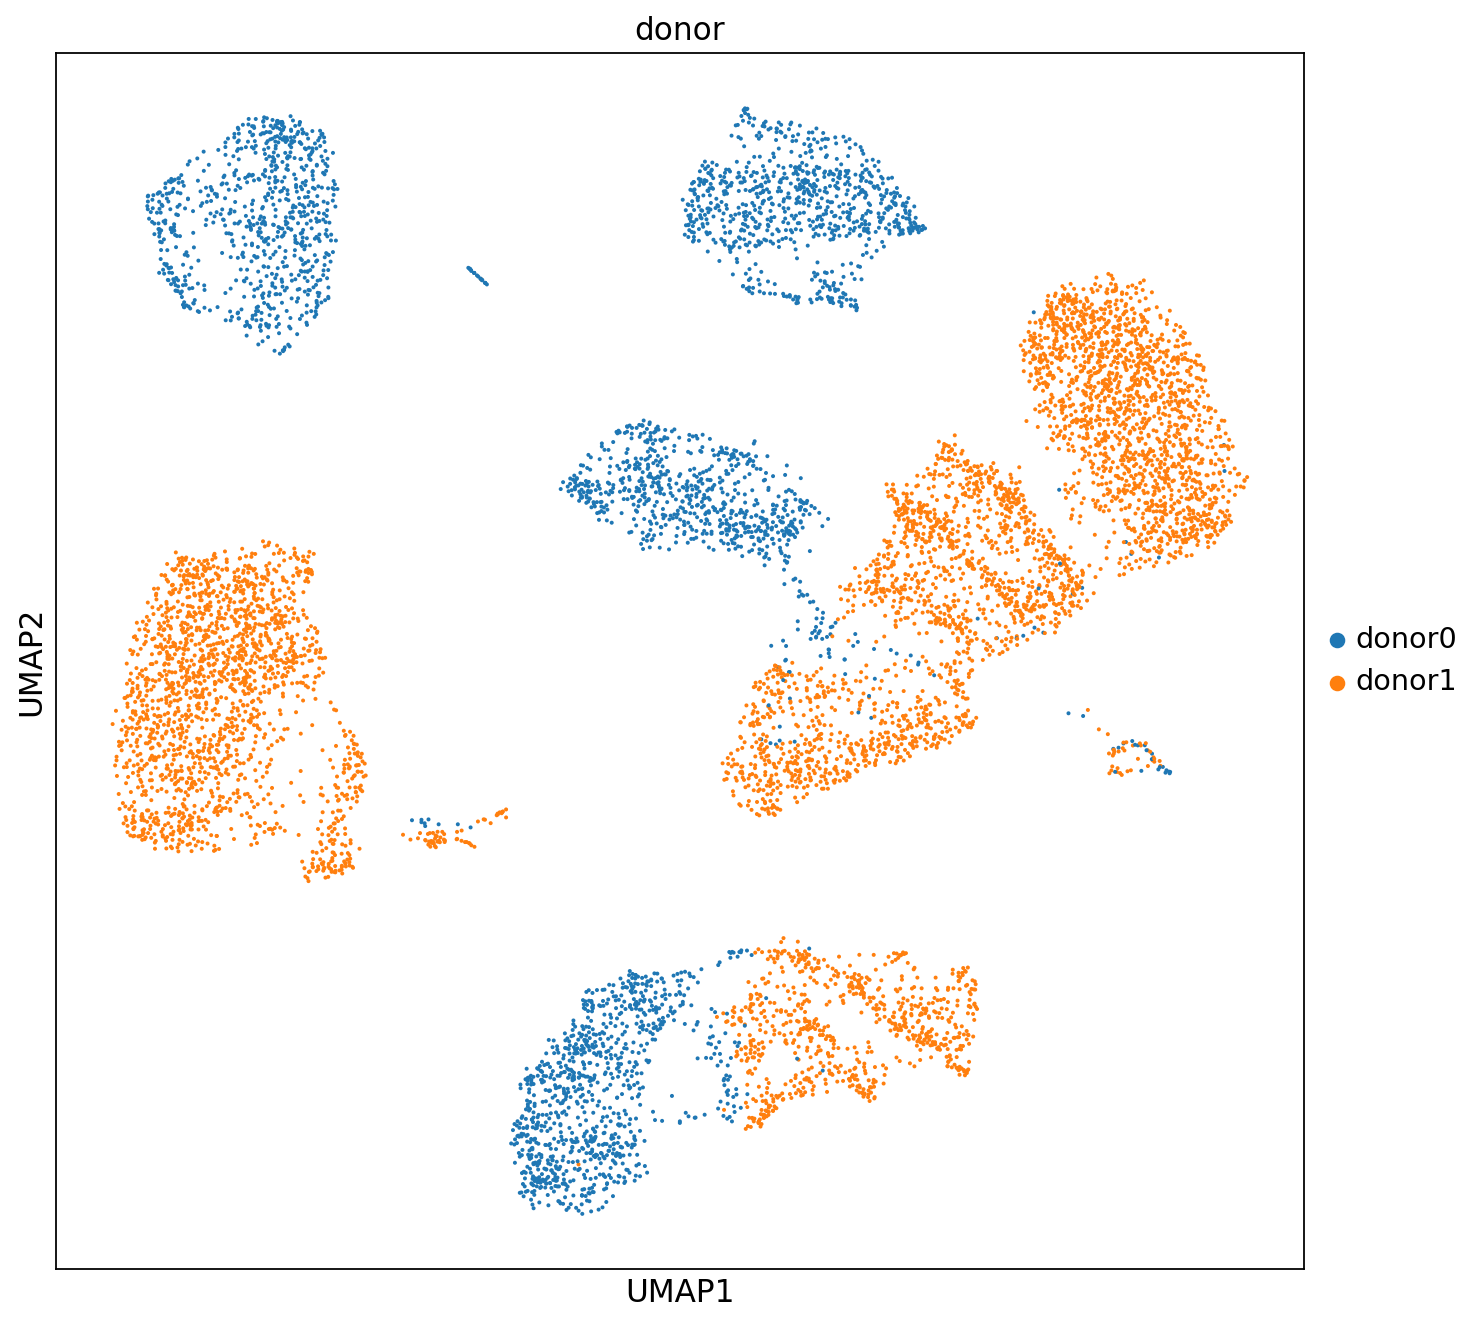

In [57]:
#Visualize with umaps
rcParams['figure.figsize']=(10,10)
sc.tl.umap(adata_final_filtered)
sc.pl.umap(adata_final_filtered, color='donor')


In [58]:
sc.tl.leiden(adata_final_filtered)

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [59]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata_final_filtered, key_added='louvain_r1.2',resolution=1.2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain_r1.2', the cluster labels (adata.obs, categorical) (0:00:00)


<Figure size 800x800 with 0 Axes>

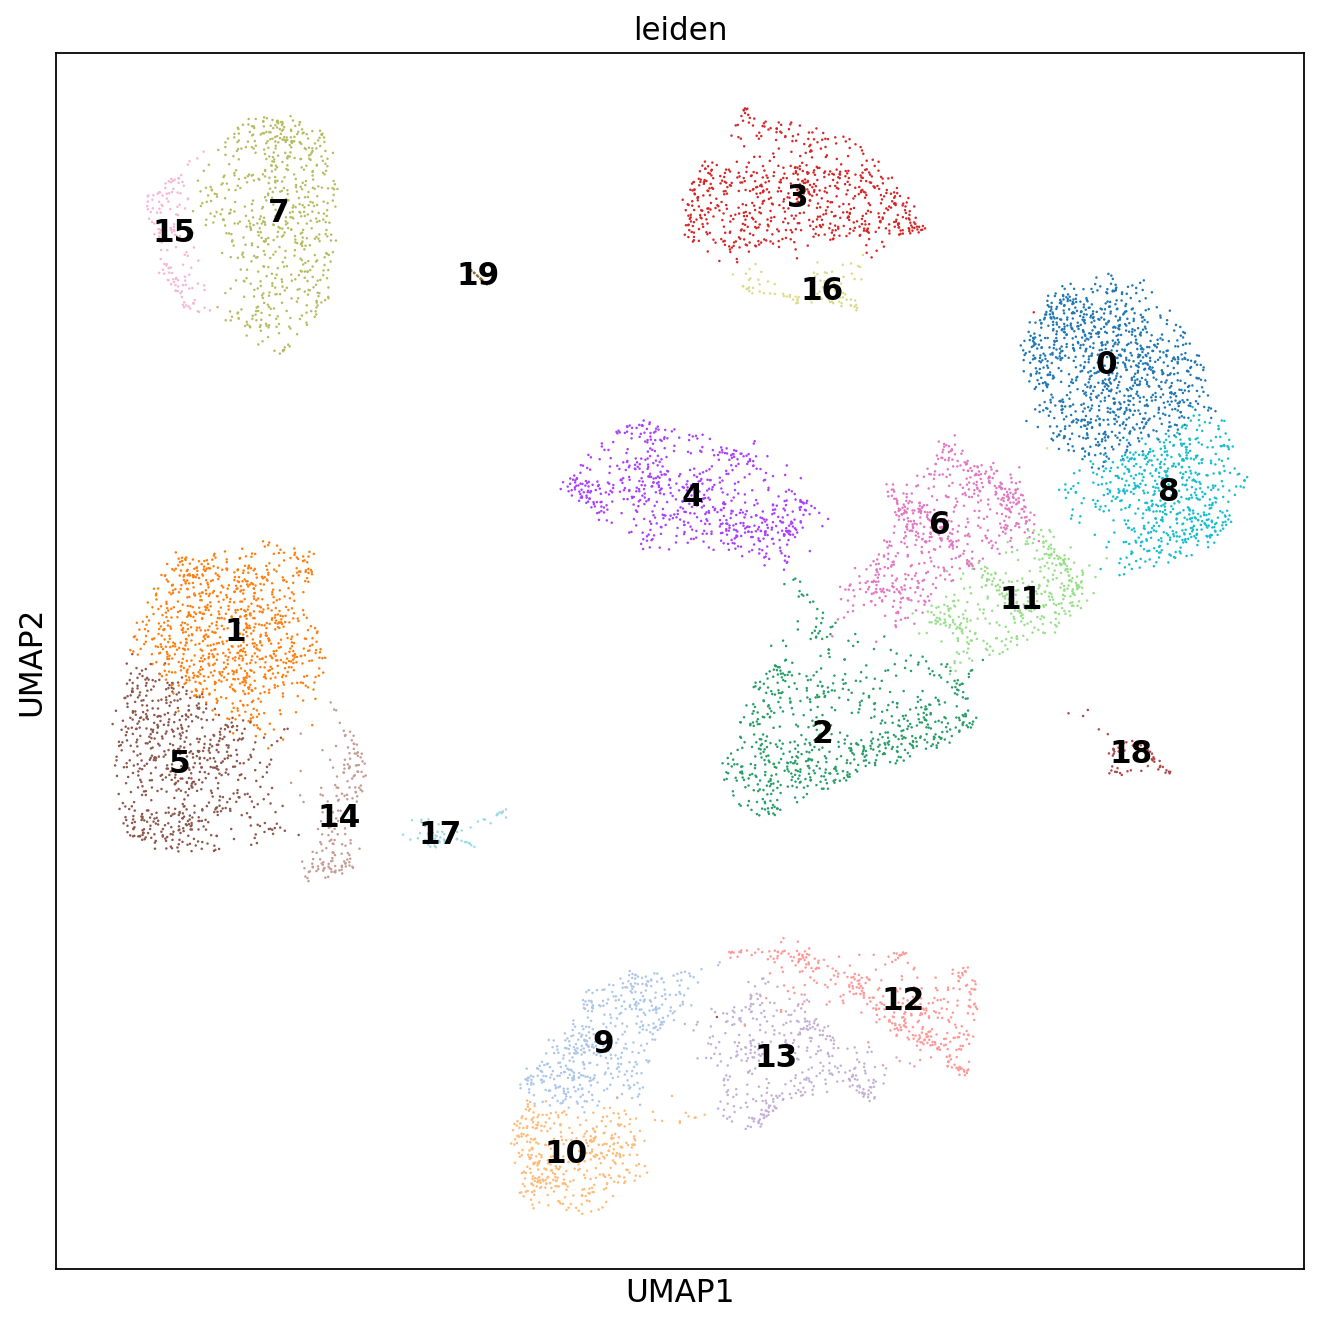

In [60]:
#Visualize the clusters with umap 
rcParams['figure.figsize']=(10,10)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

sc.pl.umap(adata_final_filtered, color=['leiden'],  legend_loc='on data',edgecolor='none', size=5, show=True, linewidths=10)

In [ ]:
sc.tl.rank_genes_groups(adata_final_filtered, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_final_filtered, n_genes=25, sharey=False)

<Figure size 800x800 with 0 Axes>

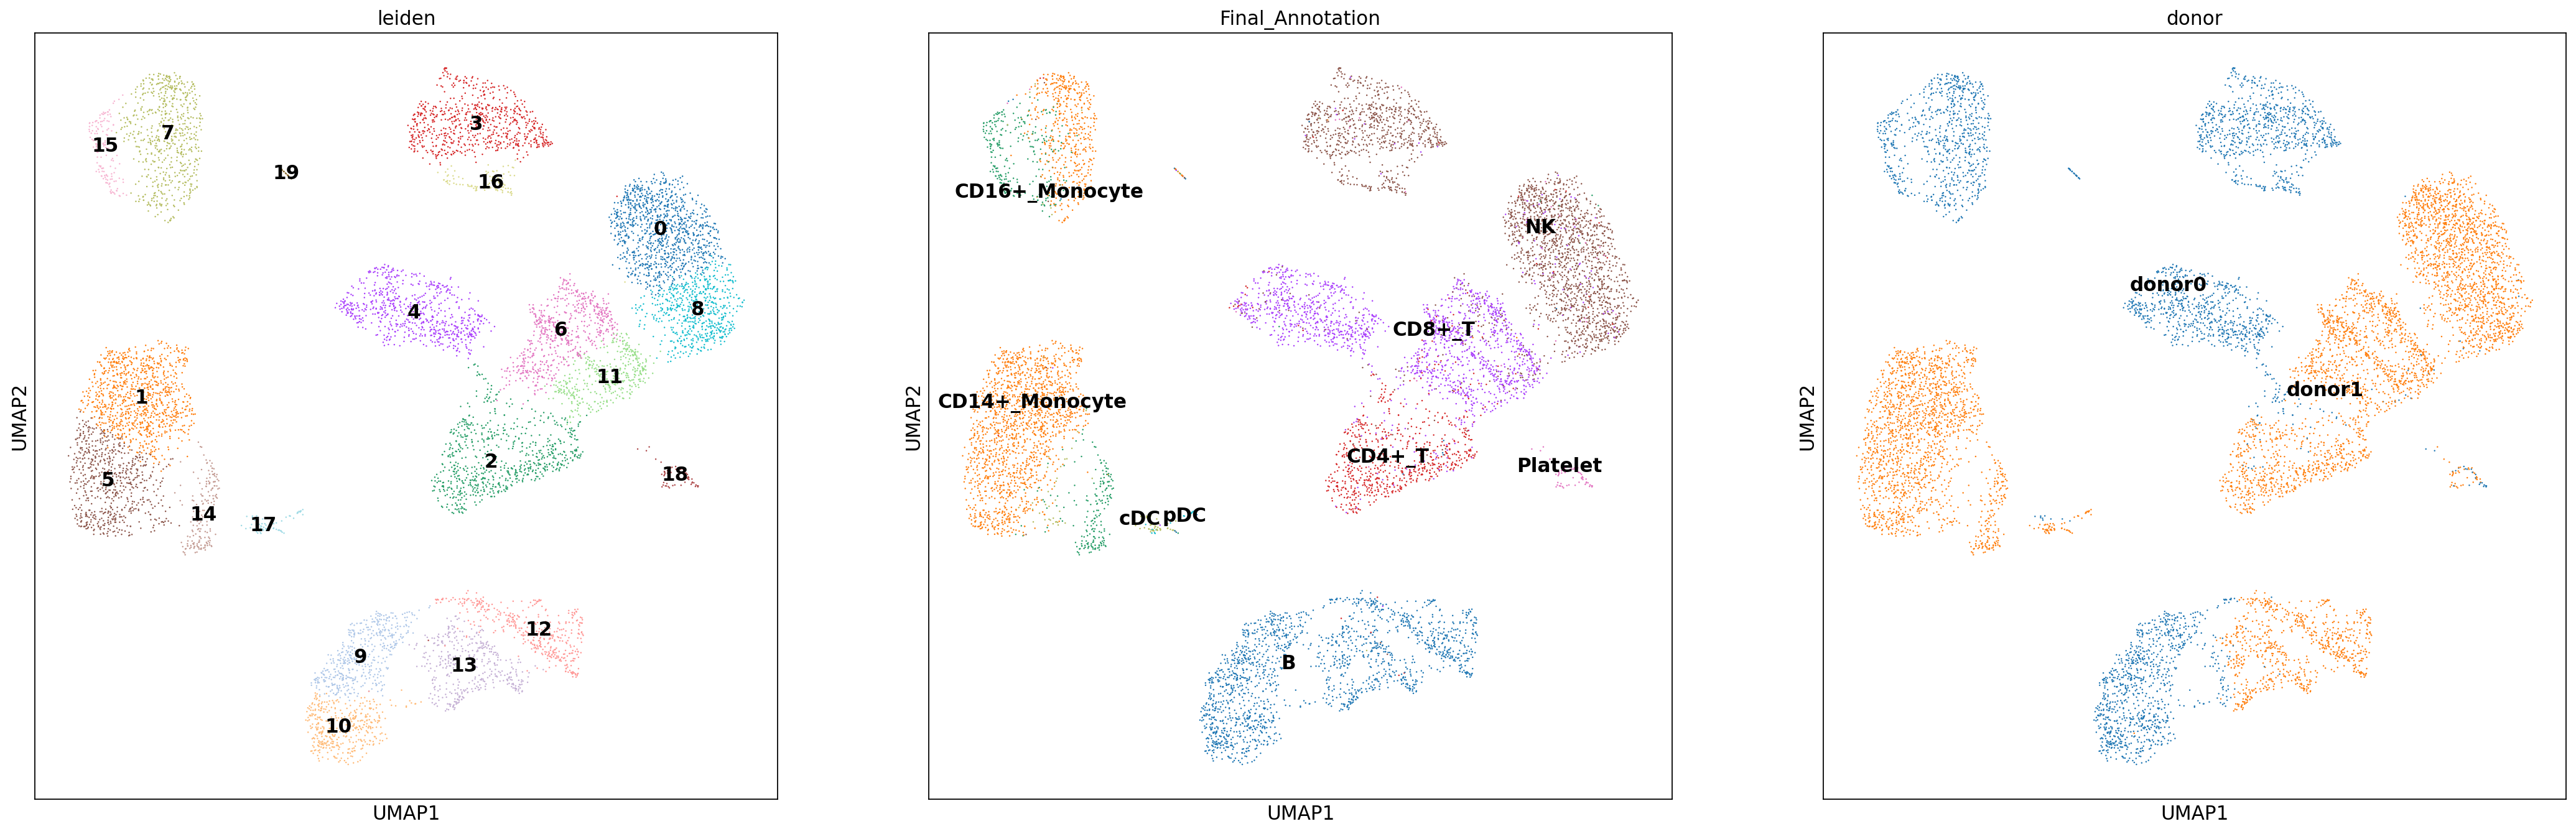

In [62]:
#Visualize the clusters with umap 
rcParams['figure.figsize']=(10,10)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

sc.pl.umap(adata_final_filtered, color=['leiden',"Final_Annotation","donor"],  legend_loc='on data',edgecolor='none', size=5, show=True, linewidths=10)

In [63]:
adata_final_filtered.obs

Final_Annotation   donor        cell_type_donor  n_genes  \
AAACCCAAGACTGGGT-1                B  donor1               B_donor1     1051   
AAACCCAAGGATATGT-1               NK  donor1              NK_donor1     2930   
AAACCCAAGGGATCGT-1           CD8+_T  donor0          CD8+_T_donor0      887   
AAACCCACAATGTCAC-1               NK  donor0              NK_donor0     1512   
AAACCCACAGATCCAT-1               NK  donor0              NK_donor0     1974   
...                             ...     ...                    ...      ...   
TTTGTTGCATAATCGC-1   CD14+_Monocyte  donor1  CD14+_Monocyte_donor1     3818   
TTTGTTGGTGCAGATG-1   CD14+_Monocyte  donor0  CD14+_Monocyte_donor0     2786   
TTTGTTGGTGCCGAAA-1               NK  donor1              NK_donor1     1471   
TTTGTTGGTTAAACCC-1               NK  donor0              NK_donor0     1525   
TTTGTTGTCACCATGA-1   CD14+_Monocyte  donor1  CD14+_Monocyte_donor1     3514   

                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGACTGGGT-1               1051        3960.0            118.0   
AAACCCAAGGATATGT-1               2930        7565.0             89.0   
AAACCCAAGGGATCGT-1                887        1383.0             10.0   
AAACCCACAATGTCAC-1               1512        3370.0             64.0   
AAACCCACAGATCCAT-1               1974        4135.0            108.0   
...                               ...           ...              ...   
TTTGTTGCATAATCGC-1               3818       15086.0            485.0   
TTTGTTGGTGCAGATG-1               2786        7999.0            120.0   
TTTGTTGGTGCCGAAA-1               1471        3012.0             98.0   
TTTGTTGGTTAAACCC-1               1525        2596.0             47.0   
TTTGTTGTCACCATGA-1               3514       12569.0            186.0   

                    pct_counts_mt leiden louvain_r1.2  
AAACCCAAGACTGGGT-1       2.979798     13           11  
AAACCCAAGGATATGT-1       1.176471      0            2  
AAACCCAAGGGATCGT-1       0.723066      2           13  
AAACCCACAATGTCAC-1       1.899110      3            3  
AAACCCACAGATCCAT-1       2.611850      3            3  
...                           ...    ...          ...  
TTTGTTGCATAATCGC-1       3.214901      1            7  
TTTGTTGGTGCAGATG-1       1.500188      7            8  
TTTGTTGGTGCCGAAA-1       3.253652      0            1  
TTTGTTGGTTAAACCC-1       1.810478      3            3  
TTTGTTGTCACCATGA-1       1.479831      1            7  

[9265 rows x 10 columns]

In [64]:
sc.tl.leiden(adata_final_filtered,key_added="leiden_2",resolution=0.13)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden_2', the cluster labels (adata.obs, categorical) (0:00:00)


In [65]:
sc.set_figure_params(vector_friendly=True,dpi=648.0)
plt.rcParams['figure.dpi'] = 500.0

In [66]:
pwd

'/home/mmokhtari/INF_analysis'

In [67]:
#Visualize the clusters with umap 
#rcParams['figure.figsize']=(10,10)
#fig_ind=np.arange(131, 133)
#fig = plt.figure()
#fig.subplots_adjust(hspace=0.4, wspace=0.6)

sc.pl.umap(adata_final_filtered, color=['leiden_2',"donor","Final_Annotation"],edgecolor='none', size=20, show=True, linewidths=10,title=["Donor","Leiden Clustering","Annotation"],save=True,wspace=0.3)

In [68]:
adata_final_filtered[adata_final_filtered.obs.Final_Annotation=="pDC"]

View of AnnData object with n_obs × n_vars = 21 × 2464
    obs: 'Final_Annotation', 'donor', 'cell_type_donor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'louvain_r1.2', 'leiden_2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'donor_colors', 'leiden', 'louvain', 'leiden_colors', 'rank_genes_groups', 'Final_Annotation_colors', 'leiden_2_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [69]:
marker_genes_dict_final = {
    'CD4+_T':['CAMK4','IL7R','BCL11B', 'LTB','FOXP3'],
    'CD8+_T':['IL7R','NELL2','CD8A','CCL5','CD3E','RFX7','AKAP9','FYN',
              'IKZF2'],
    'NK':['GNLY', 'MCTP2','XCL2', 'CD247','GZMB','NCR3','KLRB1','ARAP2','KLRC1'],
    'B':['IGHM','CD79A','CD74','EZR','CD79A','TNFRSF13C'],
    'cDC':['CST3','HLA-DRA','HLA-DPA1'],
    'CD14+_Monocyte': ['LYZ','S100A9', 'S100A8','CD14'],#
    'CD16+_Monocyte': ['LST1', 'AIF1','IFITM3','FCGR3A'],#
    'Platelet': ['PPBP','NRGN','GNG11'],#
    'pDC':["IL3RA","HLA-DRA","CLEC4C","NRP1","PTPRC","ITM2C", "PLD4", "SERPINF1", "LILRA4", "IL3RA", "TPM2",
                                       "MZB1", "SPIB", "IRF4", "SMPD3","IL12A","ZEB2","TCF4","IRF4","IRF8"]
}
marker_genes_dict_final_paper = {
    'CD4+_T':['CD4','IL7R','FOXP3'],
    'CD8+_T':['CD8A','CCL5','CD3E'],
    'NK':['GNLY','XCL2','NCR3'],
    'B':['CD19','IGHM','CD79A'],
    'cDC':['CST3','FCER1A','CLEC10A'],
    'CD14+_Monocyte': ['S100A9', 'S100A8','CD14'],#
    'CD16+_Monocyte': ['LST1','IFITM3','FCGR3A'],#
    #
    'pDC':["CLEC4C","NRP1","IL3RA"],
    'Platelet': ['PPBP','NRGN','GNG11']
}
#IL7R

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Final_Annotation']`


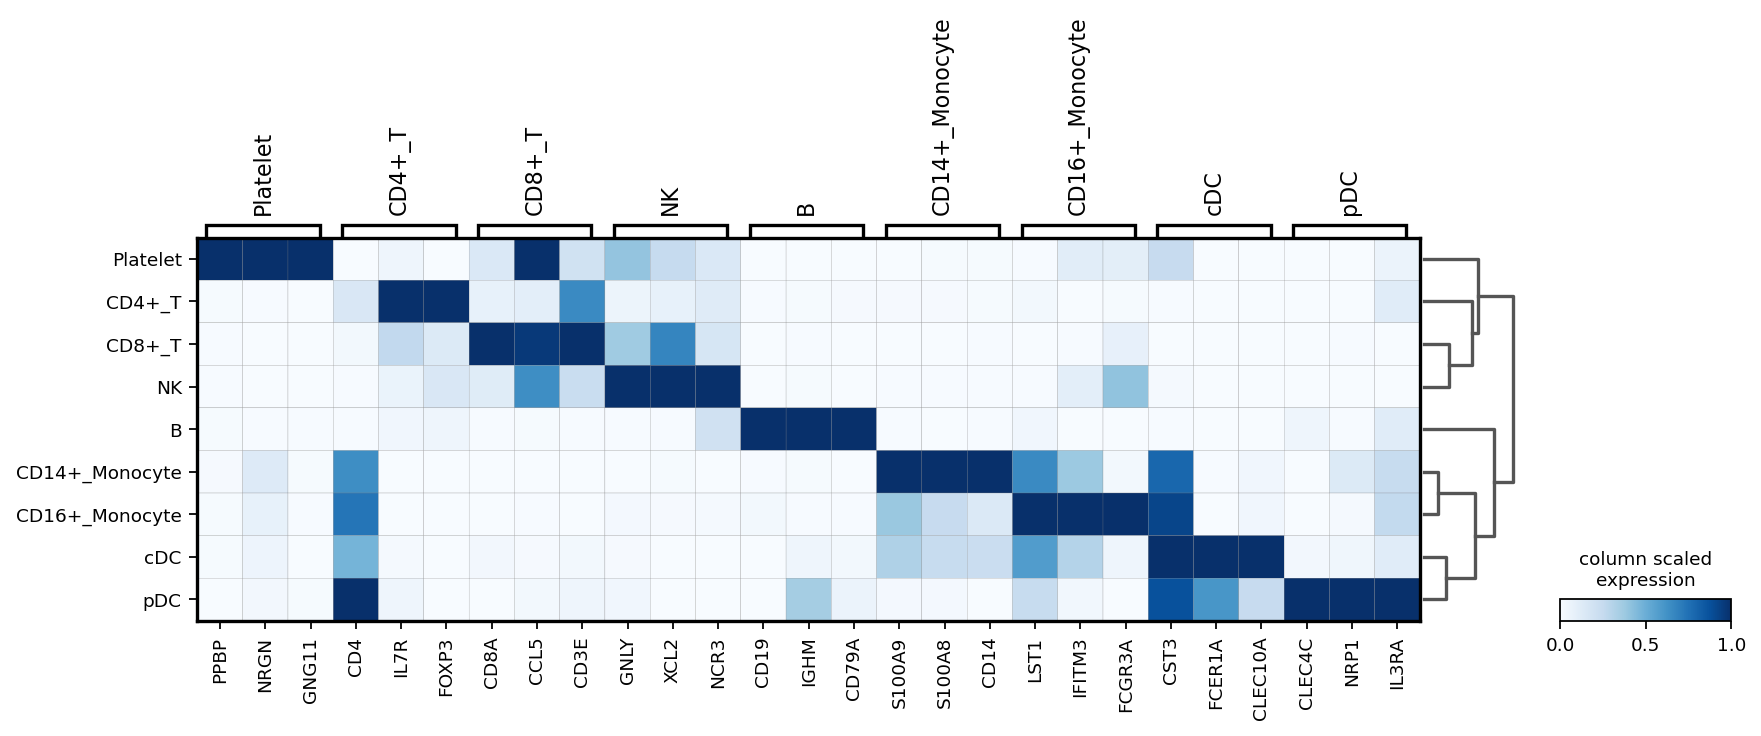

In [70]:
sc.set_figure_params(scanpy=True, fontsize=10,figsize=(8,6))

sc.pl.matrixplot(adata_final_filtered, marker_genes_dict_final_paper ,'Final_Annotation', dendrogram=True, 
                 cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression', use_raw=True,var_group_labels=[np.unique(adata_final_filtered.obs["Final_Annotation"])],save=True,
        # categories_order=['B', 'CD4+_T', 'CD8+_T','NK', 'CD16+_Monocyte','CD14+_Monocyte','cDC','pDC','Platelet']
                )